In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from state_of_the_artefact.EmbeddingVAE import EmbeddingVAE
from state_of_the_artefact.representation import create_ctable, generate_midi_data
from state_of_the_artefact.utilities import reverse_sequences, interpolate

In [157]:
x_train, y_train = reverse_sequences(x[:4500]), x[:4500]
x_val, y_val = reverse_sequences(x[4500:]), x[4500:] 

In [ ]:
cs = RecurrentVariationalAutoEncoder(10, 88, 128, 32)
cs.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [224]:
hist = cs.fit(reverse_sequences(x), x, epochs=10)

Epoch 1/10


ValueError: in user code:

    /Users/max/Dropbox/_repositories/state-of-the-artefact/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/max/Dropbox/_repositories/state-of-the-artefact/src/state_of_the_artefact/EmbeddingVAE.py:71 call  *
        z_mean, z_logvar, z = self.encode(x)
    /Users/max/Dropbox/_repositories/state-of-the-artefact/src/state_of_the_artefact/EmbeddingVAE.py:64 encode  *
        z_mean, z_logvar, z = self.encoder(x)
    /Users/max/Dropbox/_repositories/state-of-the-artefact/src/state_of_the_artefact/EmbeddingVAE.py:32 call  *
        output = self.hidden(embedded)
    /Users/max/Dropbox/_repositories/state-of-the-artefact/venv/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/max/Dropbox/_repositories/state-of-the-artefact/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /Users/max/Dropbox/_repositories/state-of-the-artefact/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_43 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 10, 88, 128]


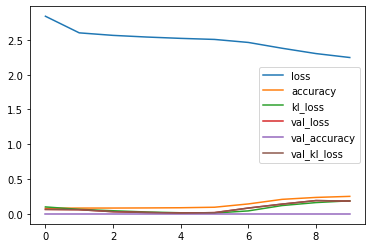

In [200]:
pd.DataFrame(hist.history).plot()

In [188]:
reconstructions = cs.predict(x_train)

missclassifieds = 0
for original, reconstruction in zip(y_train, reconstructions):
    if not np.array_equiv(decode(original), decode(reconstruction)):
        missclassifieds += 1

print(missclassifieds)

3961


In [179]:
budget = 200

data = generate_midi_data(10, 10, midi_numbers=range(24, 36))
new_y = vectorize(data)
new_x = reverse_sequences(new_y)

missclassifieds = 1
while missclassifieds > 0 and budget > 0:
    missclassifieds = 0
    history = cs.fit(new_x, new_y, epochs=1)

    reconstructions = cs.predict(new_x)

    for original, reconstruction in zip(new_y, reconstructions):
        if not np.array_equiv(decode(original), decode(reconstruction)):
            missclassifieds += 1

    budget -= 1
    print(missclassifieds, budget)


1/1 [==============================] - 0s 1ms/step - loss: 2.2126 - kl_loss_metric: 0.1649
10 199
1/1 [==============================] - 0s 1ms/step - loss: 2.2382 - kl_loss_metric: 0.1536
10 198
1/1 [==============================] - 0s 880us/step - loss: 2.2482 - kl_loss_metric: 0.1425
10 197
1/1 [==============================] - 0s 2ms/step - loss: 2.2350 - kl_loss_metric: 0.1395
10 196
1/1 [==============================] - 0s 913us/step - loss: 2.2128 - kl_loss_metric: 0.1478
10 195
1/1 [==============================] - 0s 827us/step - loss: 2.1603 - kl_loss_metric: 0.1711
10 194
1/1 [==============================] - 0s 3ms/step - loss: 2.1951 - kl_loss_metric: 0.1808
10 193
1/1 [==============================] - 0s 1ms/step - loss: 2.1492 - kl_loss_metric: 0.1909
10 192
1/1 [==============================] - 0s 2ms/step - loss: 2.1071 - kl_loss_metric: 0.1931
10 191
1/1 [==============================] - 0s 842us/step - loss: 2.1221 - kl_loss_metric: 0.1842
10 190
1/1 [=======

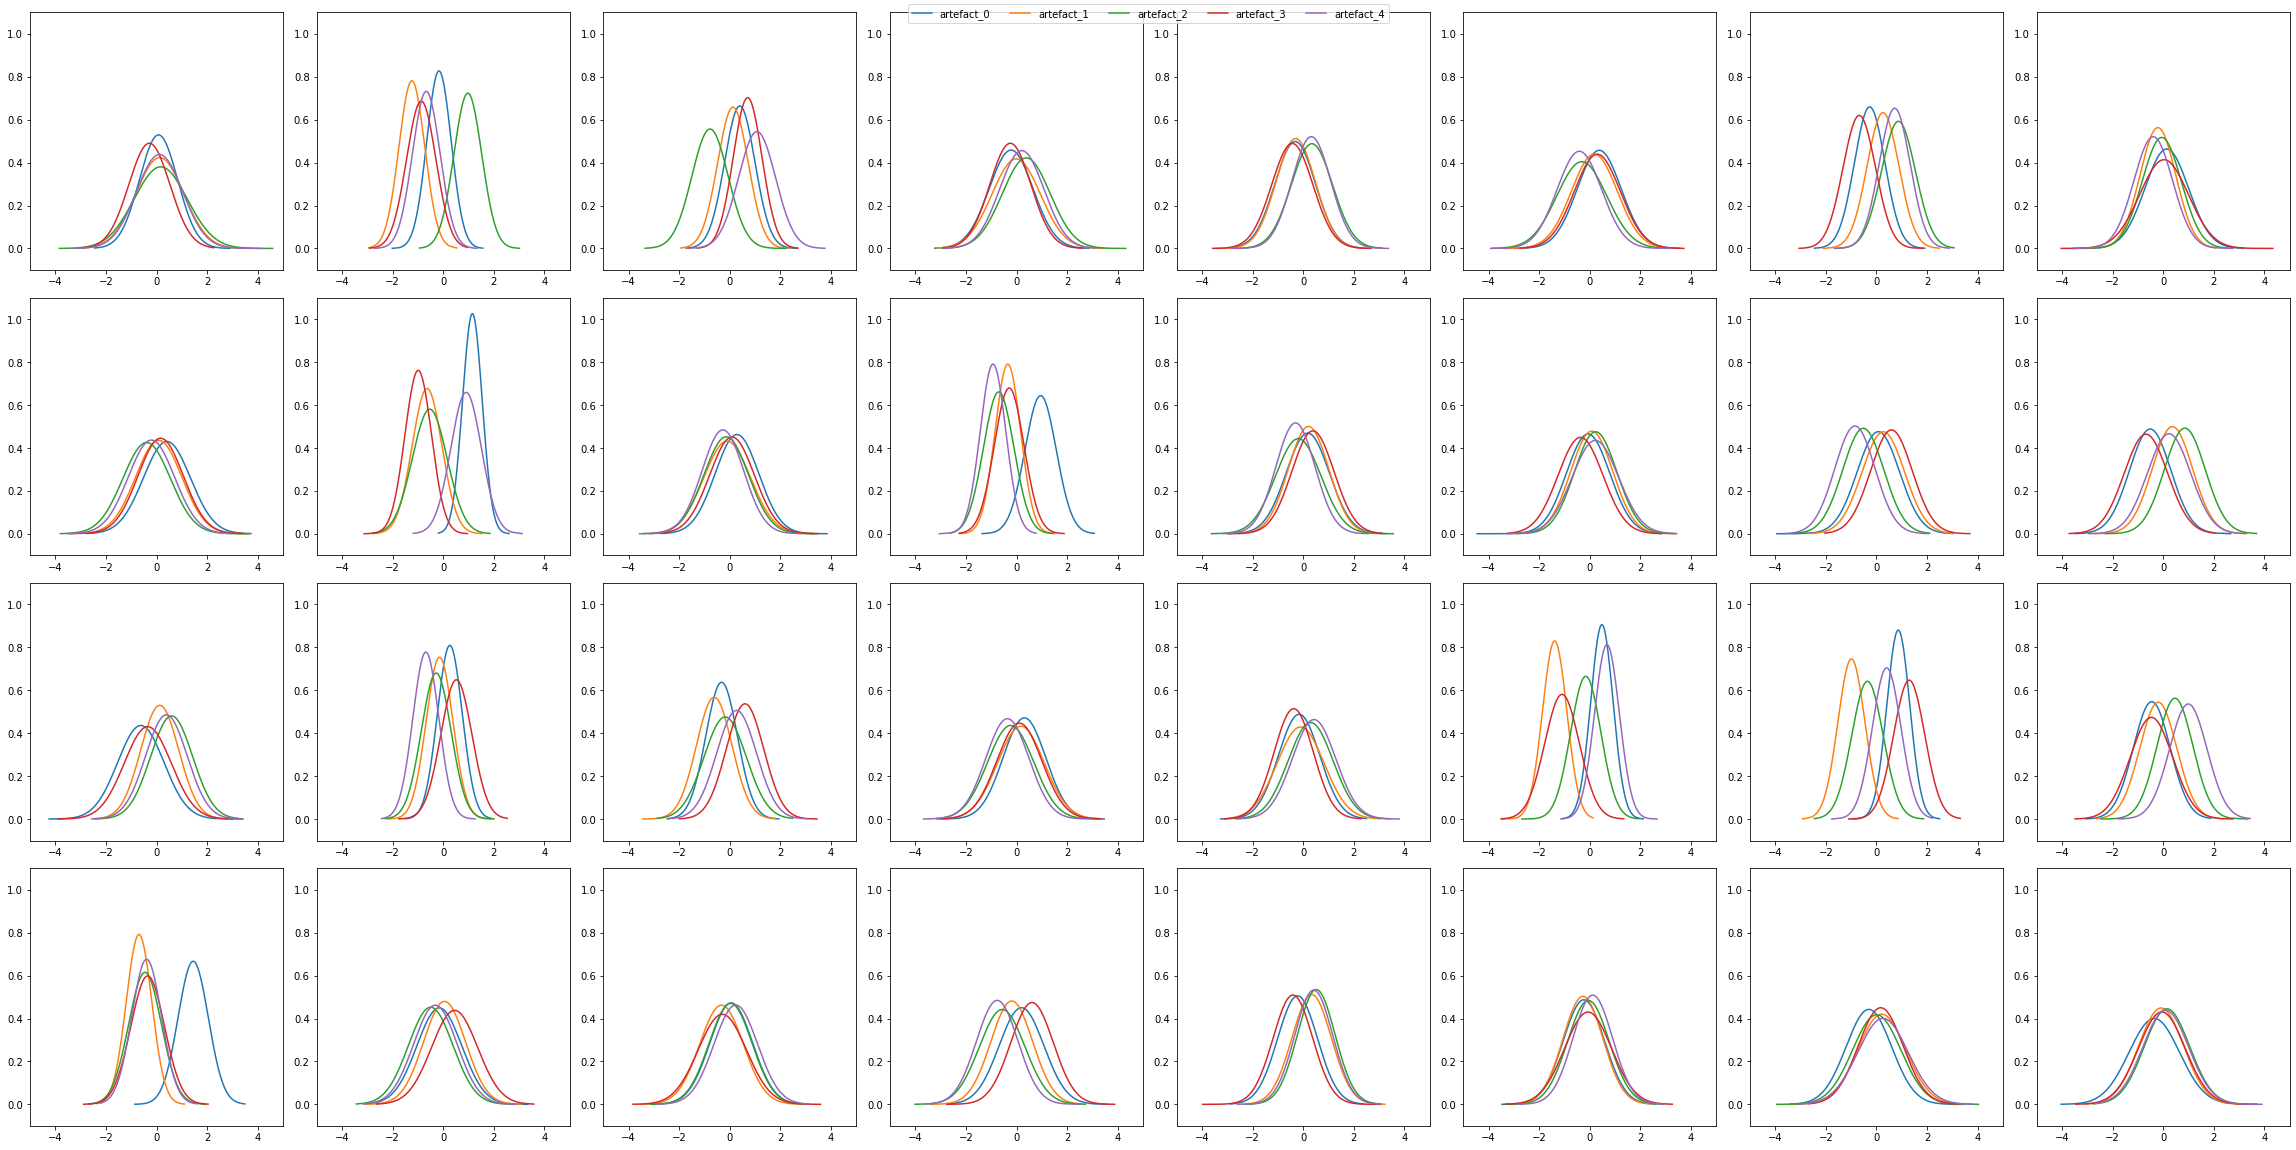

In [180]:
from scipy.stats import norm

selected_x = new_x[:5]
z_mean, z_logvar, z = cs.encode(selected_x)

fig, axs = plt.subplots(4, 8, figsize=(4 * 8, 4 * 4))
labels = [f"artefact_{i}" for i in range(0, len(selected_x))]

for i, ax in enumerate(axs.flatten()):

    for j in range(0, len(selected_x)):
        std = np.exp(0.5 * z_logvar[j][i]) # make the plots a bit saner
        h = sorted(np.random.normal(z_mean[j][i], std, 5000))
        pdf = norm.pdf(h, np.mean(h), np.std(h))
        ax.plot(h, pdf, label=labels[j])   
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-5, 5)

fig.legend(loc="upper center", labels=labels, ncol=len(new_x))
plt.tight_layout()
plt.show()

In [122]:
a = new_y[3]
b = new_y[4]

z_a = z[3]
z_b = z[4]

interpolated_z = interpolate(z_a, z_b, 10)

print(decode(a))
print('-' * 27 + ' FROM ' + '-' * 27)

i_artefacts = cs.decode(interpolated_z).numpy()

for i_a in i_artefacts:
    print(decode(i_a))

print('-' * 28 + ' TO ' + '-' * 28)
print(decode(b))

['24', '33', '30', '28', '26', '33', '30', '28', '34', '28']
--------------------------- FROM ---------------------------
['24', '33', '30', '28', '26', '33', '30', '28', '34', '28']
['24', '33', '30', '28', '26', '33', '30', '28', '34', '28']
['24', '30', '30', '28', '26', '33', '28', '34', '34', '28']
['35', '30', '24', '27', '33', '28', '34', '34', '29', '29']
['35', '24', '34', '27', '28', '28', '34', '29', '29', '31']
['35', '24', '28', '27', '31', '34', '29', '27', '27', '24']
['35', '24', '28', '27', '31', '34', '29', '27', '24', '24']
['35', '24', '28', '27', '31', '34', '29', '27', '24', '24']
['35', '24', '28', '27', '31', '34', '29', '27', '24', '24']
['35', '24', '28', '27', '31', '34', '29', '27', '24', '24']
---------------------------- TO ----------------------------
['35', '24', '28', '27', '31', '34', '29', '27', '24', '24']


In [144]:
a = new_y[3]
b = new_y[4]

z_a = z[3]
z_b = z[4]

interpolated_z = interpolate(z_a, z_b, 10)

print(decode(a))
print('-' * 27 + ' FROM ' + '-' * 27)

i_artefacts = cs.decode(interpolated_z).numpy()

for i_a in i_artefacts:
    print(decode(i_a))

print('-' * 28 + ' TO ' + '-' * 28)
print(decode(b))

['30', '29', '26', '34', '34', '25', '25', '32', '31', '24']
--------------------------- FROM ---------------------------
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '31', '24']
['30', '29', '26', '34', '34', '25', '25', '31', '31', '24']
['33', '29', '26', '31', '24', '32', '32', '31', '31', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
---------------------------- TO ----------------------------
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
